In [1]:
from model.speed_limit_detector import SpeedLimitDetector
from defense.hgd_trainer import get_HGD_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import cv2

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [3]:
detector = SpeedLimitDetector(device)
hgd = get_HGD_model(device)

In [4]:
img_paths = glob('../model/datasets/tsinghua_gtsdb_speedlimit/test2017/*.jpg')[:4]
images = []
preprocessed_imgs = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    images.append(img)
    img = detector.preprocess(img)
    preprocessed_imgs.append(img)

In [5]:
print(len(preprocessed_imgs))

4


In [6]:
def plot_images(images, title="",transpose=False, rgb=True):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    axs = axs.flatten()
    for i, img in enumerate(images):
        img = img.transpose((1, 2, 0)) if transpose else img
        img = np.asarray(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if rgb else img
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

In [7]:
@torch.no_grad()
def denoise(images):
    images_tensor = torch.from_numpy(np.asarray(images))
    hgd.eval()
    noise = hgd(images_tensor)
    denoised = images_tensor - noise
    return denoised.cpu().numpy(), noise.cpu().numpy()

In [8]:
@torch.no_grad()
def detect_sign(images):
    images_tensor = torch.from_numpy(np.asarray(images))
    outputs = detector.get_model_output(images_tensor)
    decoded_outputs = []
    for output in outputs:
        decoded_outputs.append(detector.decode_model_output(output))
    return decoded_outputs

In [9]:
from attack.fgsm import FGSM
from attack.iterative_fgsm import ItFGSM
from attack.pgd import PGD
from model.custom_yolo import yolox_loss, yolox_target_generator

fgsm = FGSM()
fgsm.model = detector.model
fgsm.target_generator = yolox_target_generator
fgsm.loss = yolox_loss

it_fgsm = ItFGSM()
it_fgsm.model = detector.model
it_fgsm.target_generator = yolox_target_generator
it_fgsm.loss = yolox_loss

pgd = PGD()
pgd.model = detector.model
pgd.target_generator = yolox_target_generator
pgd.loss = yolox_loss

In [10]:
fgsm_attacked_images = []
it_fgsm_attacked_images = []
pgd_attacked_images = []

for img in preprocessed_imgs:
    img = torch.from_numpy(img[None, :, :, :])
    fgsm_attacked = fgsm.generate_attack(img, return_numpy=True)[0]
    it_fgsm_attacked = it_fgsm.generate_attack(img, return_numpy=True)[0]
    pgd_attacked = pgd.generate_attack(img, return_numpy=True)[0]

    fgsm_attacked_images.append(fgsm_attacked)
    it_fgsm_attacked_images.append(it_fgsm_attacked)
    pgd_attacked_images.append(pgd_attacked)

100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


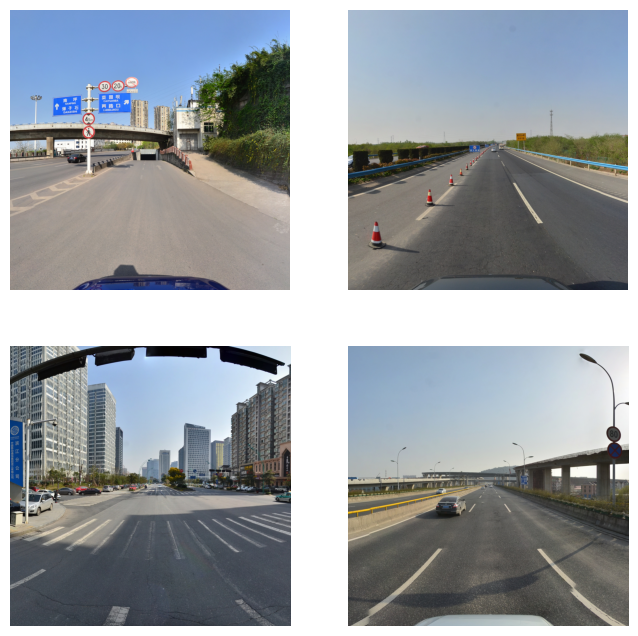

In [11]:
plot_images(images)

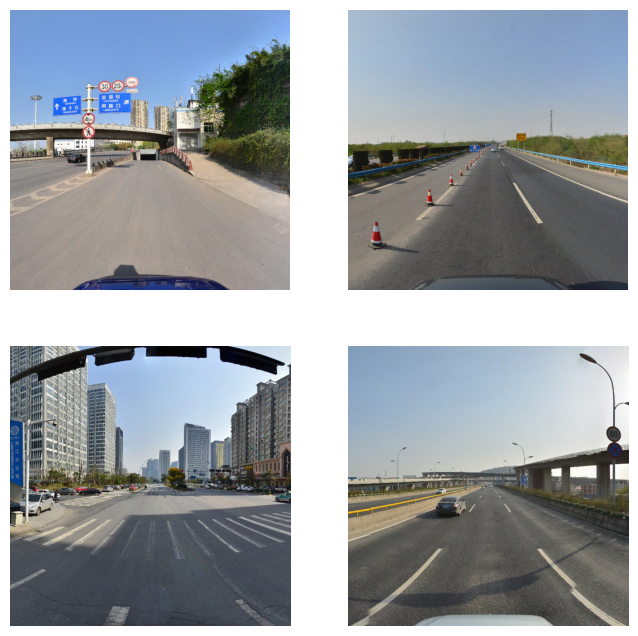

In [12]:
plot_images(fgsm_attacked_images, transpose=True)

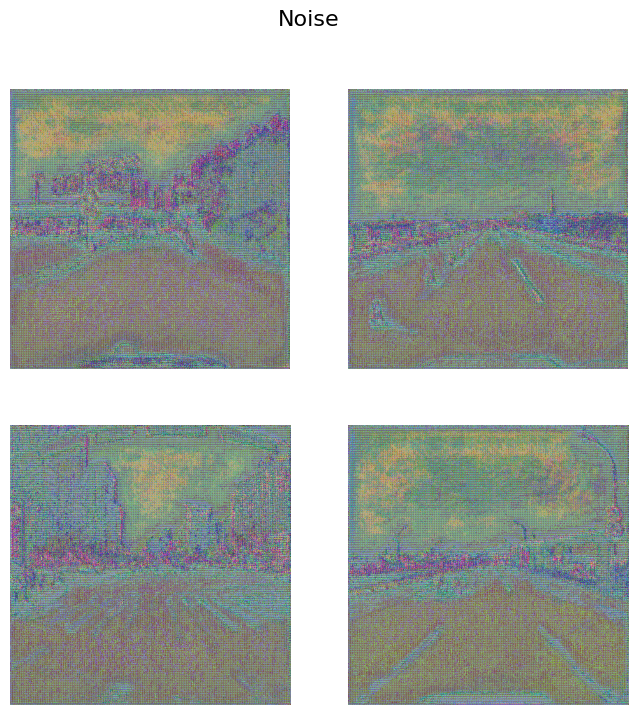

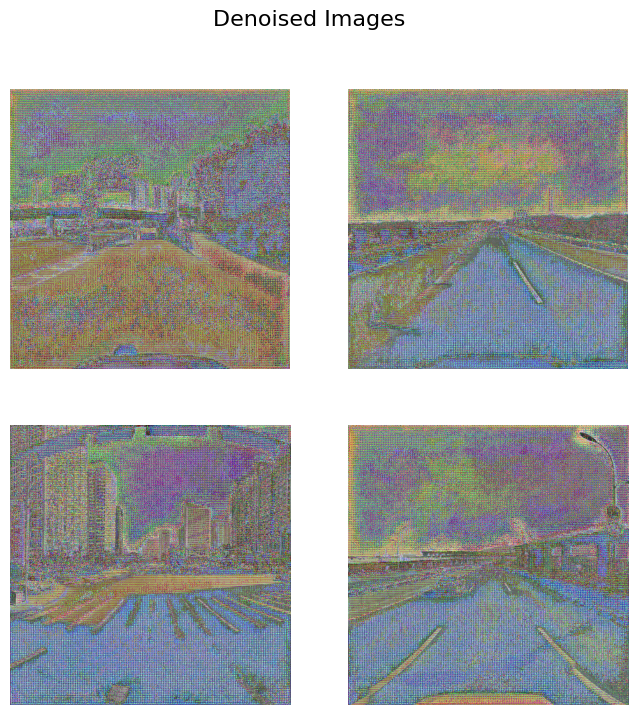

IndexError: arrays used as indices must be of integer (or boolean) type

In [13]:
denoised_fgsm, noise_fgsm = denoise(fgsm_attacked_images)
plot_images(noise_fgsm, title="Noise",transpose=True)
plot_images(denoised_fgsm, title="Denoised Images",transpose=True, rgb=False)
detect_sign(denoised_fgsm)

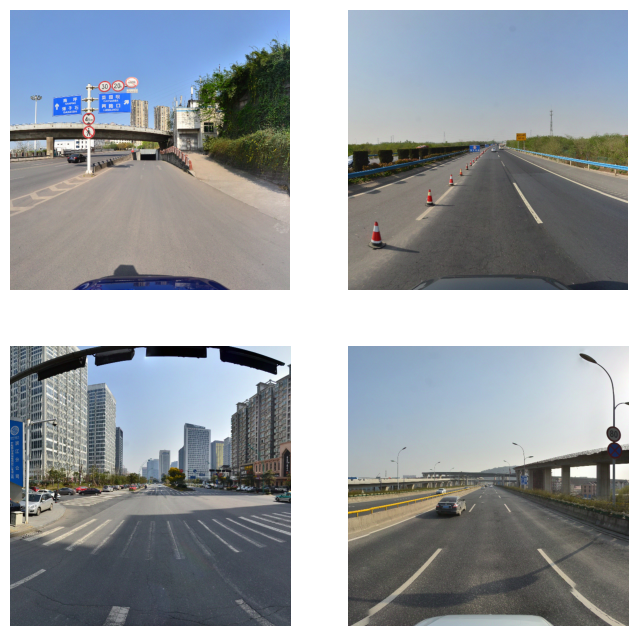

In [ ]:
plot_images(it_fgsm_attacked_images, transpose=True)

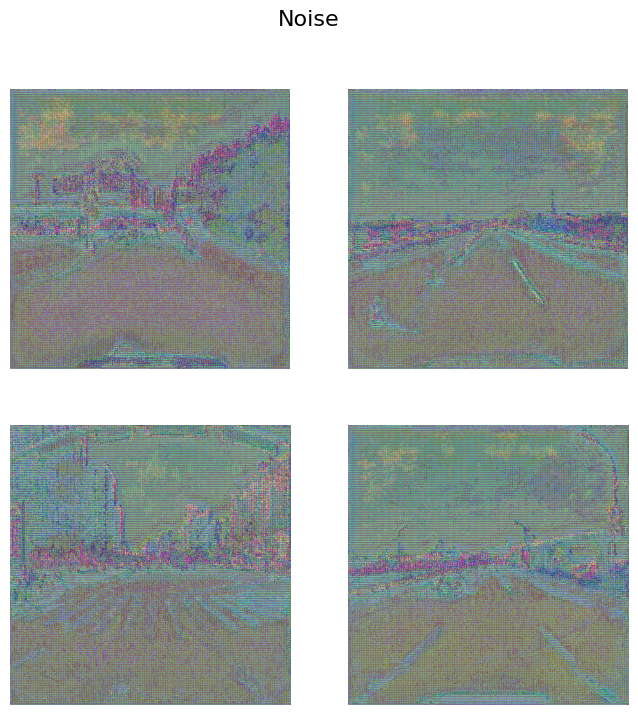

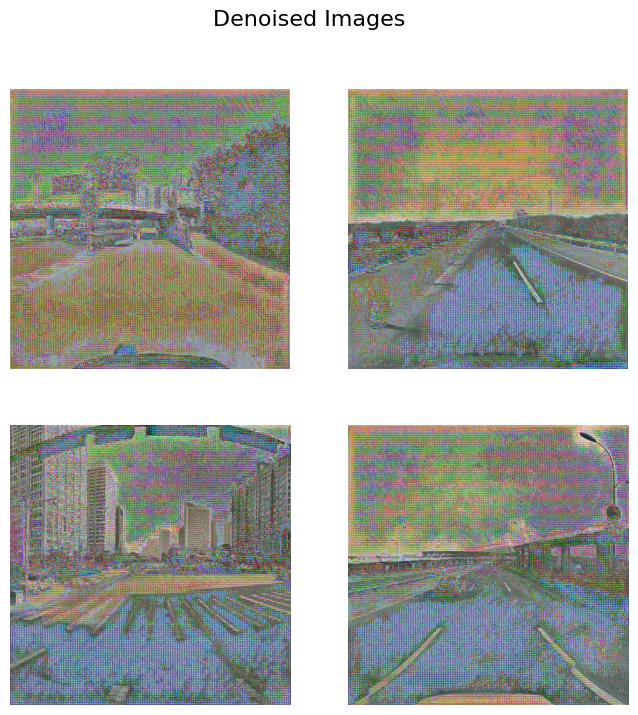

In [41]:
denoised, noise = denoise(it_fgsm_attacked_images)
plot_images(noise, title="Noise",transpose=True)
plot_images(denoised, title="Denoised Images",transpose=True, rgb=False)